In [309]:
import random
import time
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# primitive_polynomials_data = [1,3,7,11,13,19,25,37,59,47,61,55,41,67,97,91,109,103,115,131]
# print(len(primitive_polynomials_data))
# m_value_data = [[1],[1],[1,1],[1,3,7],[1,1,5],[1,3,1,1],[1,1,3,7],[1,3,3,9,9],[1,3,7,13,3],[1,1,5,11,27],[1,3,5,1,15],\
# [1,1,7,3,29],[1,3,7,7,21],[1,1,1,9,23,37],[1,3,3,5,19,33],[1,1,3,13,11,7],[1,1,7,13,25,5],[1,3,5,11,7,11],[1,1,1,3,13,39],\
# [1,3,1,15,17,63,13]]
# print(len(m_value_data))

In [467]:
#Hyperparameters
MAX_DIM = 21201

### Utility functions

In [468]:
def evaluate_halton(a,b=2):
    ans = 0
    n = len(a)
    for i in range(n):
        ans = ans * b + a[i]
    return ans

def binary_array(n,b=2):
    if n == 0:
        return [0]
    ans = []
    while n > 0:
        i, remainder = divmod(n, b)
        ans.append(remainder)
        n = n//2
    ans.reverse()
    return ans

def rightmost_zero_index(a):
    n = len(a)
    index = n
    for i in range(n):
        if a[i] == 0:
            index = n - 1 - i 
    return index

def graycode2(n):
    if n==0:
        return [0]
    ans = n ^ int(n/2.0)
    return binary_array(ans)

def next_bary(a_in,b = 2):
    m = len(a_in)
    a_out = [0 for i in range(m)]
    carry = True
    for i in range(m):
        if carry:
            if (a_in[m-1-i] == b-1):
                a_out[m-1-i] = 0
            else:
                a_out[m-1-i] = a_in[m-1-i]+1
                carry = False
        else:
            a_out[m-1-i] = a_in[m-1-i]
    if carry:
        a_out = [1] + a_out
    return a_out

### Class Sobol

In [478]:
class sobol_generator():
    
    def __init__(self,d):
        
        if (d > MAX_DIM):
            print("Error: Maximum dimension is %d" %(MAX_DIM))
            return
    
        self.dim = d
        self.primitive_polynomials_data = []
        self.m_value_data = []
        self.load()
    
    def sobol_mat(self, c_vec, m_init, r):
        q = len(c_vec)-1
        if q == 0 :
            V = np.identity(r)
            return V
        V = np.zeros((r,r))
        m_vec = [0 for i in range(r)]
        m_vec[:len(m_init)] = m_init
        m_state=m_init
        for i in range(q,r):
            m_next = 0
            for j in range(q):
                m_next = m_next ^ (pow(2,j+1) * c_vec[j] * m_state[q-1-j])
            m_next = m_next ^ m_state[0]
            m_vec[i] = m_next
            m_state = m_state[1:q+1] + [m_next]
        for j in range(r):
            m_bin = binary_array(m_vec[j],b=2)
            k = len(m_bin)
            for i in range(k):
                V[j-i,j]=m_bin[k-i-1]
        return V
    
    def sobol_pts(self,n_pts):
        c_time = time.time()
        r_max = 1+int(math.log(n_pts)/math.log(2))
        P = np.zeros((self.dim,n_pts))
        y = np.zeros((r_max,self.dim))
        a = [0]
        V = np.zeros((self.dim,r_max,r_max))
        for i in range(self.dim):
            q = len(self.m_value_data[i])
            V[i] = self.sobol_mat(self.primitive_polynomials_data[i],self.m_value_data[i],r_max)
        b_pwrs = []
        for i in range(r_max):
            b_pwrs.append(pow(1/2,i+1))

        print("To load the matrix we needed: %.3f seconds" %(time.time() - c_time))
        c_time = time.time()
        for k in range(n_pts):

            l = rightmost_zero_index(a)
            a = next_bary(a,2)

            y = (y + V[:,:,l].T)%2

            P[:,k] = P[:,k] + np.dot(b_pwrs,y)

        print("To generate the sample we needed: %.3f seconds" %(time.time() - c_time))
        return P
    
    def sample(self,n_pts):
        return self.sobol_pts(n_pts)
        

    def load(self):
        self.primitive_polynomials_data = [[1],[1,1]]
        self.m_value_data = [[],[1]]
        my_data = np.genfromtxt('new-joe-kuo-6-21201.csv', delimiter=';',dtype=int)
        for i in range(3,21202):
            s = my_data[i,1]

            polynome_add = binary_array(my_data[i,2])
            while (len(polynome_add) < s-1):
                 polynome_add = [0] + polynome_add
            polynome_add = [1] + polynome_add + [1]
            m_add = []
            for j in range(s):
                m_add.append(my_data[i,3+j])
            self.primitive_polynomials_data.append(polynome_add)
            self.m_value_data.append(m_add)
    

### Examples

To load the matrix we needed: 0.087 seconds
To generate the sample we needed: 0.534 seconds
512


Text(0, 0.5, 'Dimension 2')

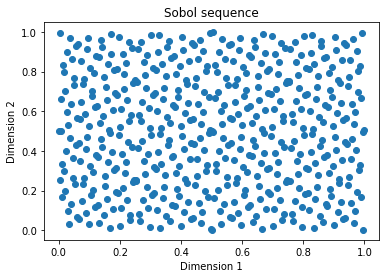

In [489]:
sampler = sobol_generator(21201)
sample = sampler.sample(512)
print(len(sample[0]))
plt.figure()
plt.scatter(sample[0,:],sample[1,:])
plt.title("Sobol sequence")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

To load the matrix we needed: 0.931 seconds
To generate the sample we needed: 7.003 seconds
512


Text(0, 0.5, 'Dimension 10764')

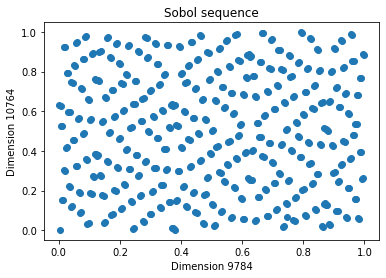

In [491]:
sampler = sobol_generator(21201)
sample = sampler.sample(512)
print(len(sample[0]))
plt.figure()
plt.scatter(sample[9783,:],sample[10764,:])
plt.title("Sobol sequence")
plt.xlabel("Dimension 9784")
plt.ylabel("Dimension 10764")